In [1]:
import lxml
from lxml import html
import requests
import pandas as pd
import time
import re
import sys
import os
import undetected_chromedriver as uc

from datetime import date
from bs4 import BeautifulSoup
from requests.exceptions import RequestException
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from fake_useragent import UserAgent

In [2]:
def web_driver():
    options = webdriver.ChromeOptions()
    options = Options()
    options.add_argument(f"user-agent={user_agent}")
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)

    driver  = uc.Chrome(headless=True,use_subprocess=False)
    driver.get(url)
    return driver  

ua = UserAgent()
user_agent = ua.random
date_today = date.today().strftime("%d/%m/%Y")
#ASIN = 'B06XKMH86J'
ASIN = 'B08FDYL6RZ'
baseURL = 'https://www.amazon.sa'
url= f"https://www.amazon.sa/-/en/VIVOSUN-Temperature-Hydroponics-Household-Certified/dp/{ASIN}"
url_reviews = f"https://www.amazon.sa/-/en/VIVOSUN-Temperature-Hydroponics-Household-Certified/product-reviews/{ASIN}/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

driver = web_driver() # calling the function
# Make the request for the product page
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

# Delay before making the request for reviews page
time.sleep(2)  # Adjust delay as needed

driver2  = uc.Chrome(headless=True,use_subprocess=False)
driver2.get(url_reviews)
# Make the request for the reviews page
soup_reviews = BeautifulSoup(driver2.page_source, "html.parser")
#print("Product page status code:", page_source2)

# Close the drivers
driver2.quit()

Product page status code: None


In [11]:
print("Product page status code:", soup.status_code)

Product page status code: None


In [3]:
 
Additional_Information = soup.find("div", {"id":"productDetails_db_sections"}).text.strip()
 
Additional_Information  



'Additional Information     Batteries   1 Product Specific batteries required. (included)     Date First Available   7 August 2020    Customer Reviews  \n\n \n   4.2  4.2 out of 5 stars    \n    117 ratings   \n\n\n 4.2 out of 5 stars     Best Sellers Rank    #6,127 in Sporting Goods (See Top 100 in Sporting Goods)  #22 in Bike Headlight-Taillight Combinations'

In [13]:
# Find sub-category page link
def sub_category(soup):
    category_links = []
    
    sub_category_list = soup.find_all("table", {"id":"productDetails_detailBullets_sections1"})
    for sub_category in sub_category_list:
        for link in sub_category.find_all('a', href=True):
            category_links.append(baseURL + link['href'])
    
    # Get the last sub-category link
    sub_category_link = category_links[-1]
    return sub_category_link  

sub_category_link = sub_category(soup)
sub_category_link

'https://www.amazon.sa/-/en/gp/bestsellers/sports-goods/28397901031/ref=pd_zg_hrsr_sports-goods'

In [52]:
#this function returns the best seller in sub category
def sub_URLs(soup, sub_category_link, baseURL):
    best_seller_link = []
    img_urls = []
    response = requests.get(sub_category_link)
    tree = html.fromstring(response.content)
    # Use XPath to extract the href attribute of the <a> tag
    link = tree.xpath("/html/body/div[1]/div[2]/div/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/div/div/a/@href")
    best_seller_link.append(baseURL+link[0])

    #get img elements urls for the 1st page
    img_elements = tree.xpath("//div/a/div/img")
    for img in img_elements:
        img_url = img.get("src")
        img_urls.append(img_url)

    # Identify next page links, then use it to parse imgs for each page then add it into the img_urls list 
    links = []
    response = requests.get(sub_category_link)
    tree = html.fromstring(response.content)
    next_page_links = tree.xpath("//a[contains(text(), 'Next')]/@href")
    for i in range(len(next_page_links)):
        links.append(baseURL + next_page_links[i])

    #links contains the urls for the next pages
    # now #get img elements urls for the other pages then add it into the img_urls list 
    for i in links:
        response = requests.get(i)
        tree = html.fromstring(response.content)
        for img in img_elements:
            img_url = img.get("src")
            img_urls.append(img_url)
    
    return best_seller_link, img_urls

best_seller_link = sub_URLs(soup, sub_category_link, baseURL)[0]
img_urls = sub_URLs(soup, sub_category_link, baseURL)[1]

In [54]:
len(img_urls)

100

In [93]:
#img_urls and best_seller_link
def sub_URLs(sub_category_link, baseURL):
    best_seller_link = []
    img_urls = []
    
    # Perform initial request to get the best seller link and first page img URLs
    response = requests.get(sub_category_link)
    tree = html.fromstring(response.content)
    
    # Extract the best seller link
    link = tree.xpath("/html/body/div[1]/div[2]/div/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/div/div[2]/div/div/div/a/@href")
    if link:
        best_seller_link.append(baseURL + link[0])

    # Extract img elements URLs for the 1st page
    img_elements = tree.xpath("//div/a/div/img")
    img_urls.extend([img.get("src") for img in img_elements])
    
    # Extract next page links
    next_page_links = tree.xpath("//a[contains(text(), 'Next')]/@href")
    next_page_links = [baseURL + link for link in next_page_links]
    
    # Loop through next page links to get img URLs
    for link in next_page_links:
        response = requests.get(link)
        tree = html.fromstring(response.content)
        img_elements = tree.xpath("//div/a/div/img")
        img_urls.extend([img.get("src") for img in img_elements])
    
    return best_seller_link, img_urls

best_seller_link = sub_URLs(sub_category_link, baseURL)[0]
img_urls = sub_URLs(sub_category_link, baseURL)[1]

In [94]:
print(best_seller_link)
len(img_urls)

['https://www.amazon.sa/-/en/SUYAYA-Rechargeable-Set-Bike-Waterproof-Bicycles/dp/B08MYFX5C6/ref=zg_bs_g_28397901031_d_sccl_1/000-0000000-0000000?psc=1']


100

In [95]:
img_urls

['https://images-eu.ssl-images-amazon.com/images/I/51pFVs7JiQS._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/61m1PsVUqTL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/71eBJ1dOIKL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/61BnnmzmsSL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/61wlr86VO0L._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/619WZi6n-2L._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/51iIyhwkoqL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/51-imFhy8CL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/71ZzL+-T1EL._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/51QAj8M9v6L._AC_UL300_SR300,200_.jpg',
 'https://images-eu.ssl-images-amazon.com/images/I/51s3SN2MgLL._AC_UL300_SR300,200_.jpg',
 'https://

In [96]:
import requests
from PIL import Image
from io import BytesIO


# List to store images
images = []

# Function to download and store images
def download_images(img_urls):
    for idx, url in enumerate(img_urls):
        try:
            # Get the image from the URL
            response = requests.get(url)
            response.raise_for_status()  # Check if the request was successful
            
            # Open the image and convert it to RGB
            img = Image.open(BytesIO(response.content)).convert("RGB")
            
            # Append the image to the list
            images.append(img)
            
            print(f'Successfully downloaded image from {url}')
        except Exception as e:
            print(f'Failed to download {url}: {e}')

# Download and store the images
download_images(img_urls)

# Now `images` contains all the downloaded images
# You can process them further as needed


Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/51pFVs7JiQS._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/61m1PsVUqTL._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/71eBJ1dOIKL._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/61BnnmzmsSL._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/61wlr86VO0L._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/619WZi6n-2L._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/51iIyhwkoqL._AC_UL300_SR300,200_.jpg
Successfully downloaded image from https://images-eu.ssl-images-amazon.com/images/I/51-imFhy8CL._AC_UL300_SR300,200_.jpg
Successfully downloaded image fr

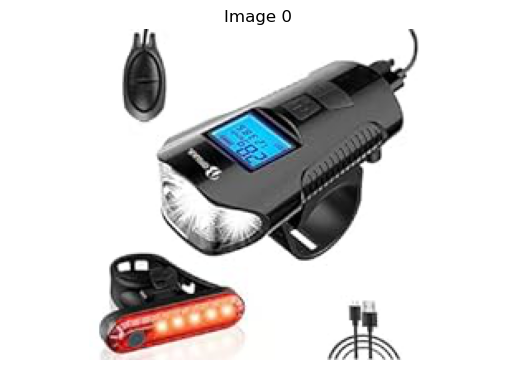

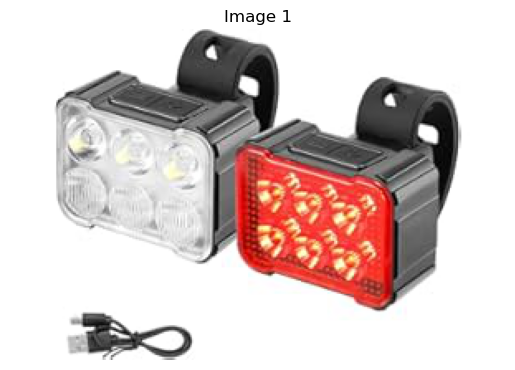

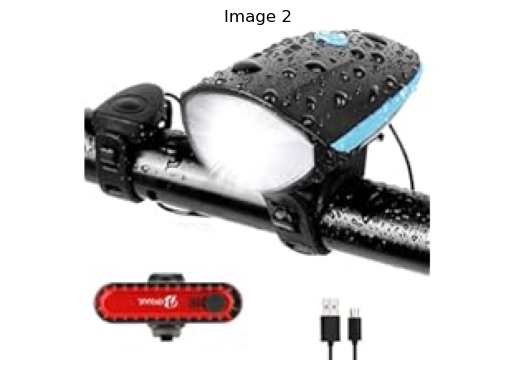

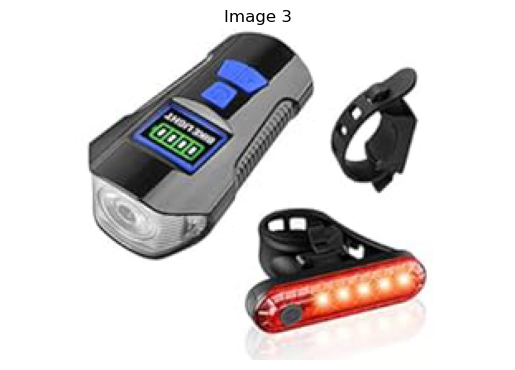

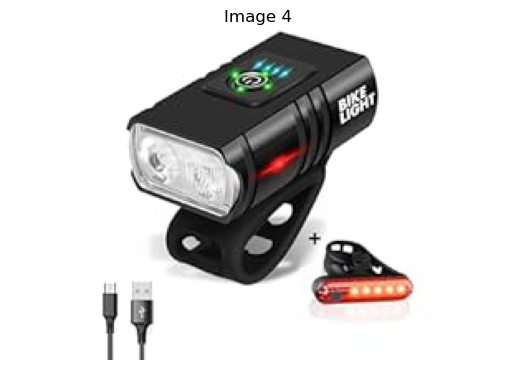

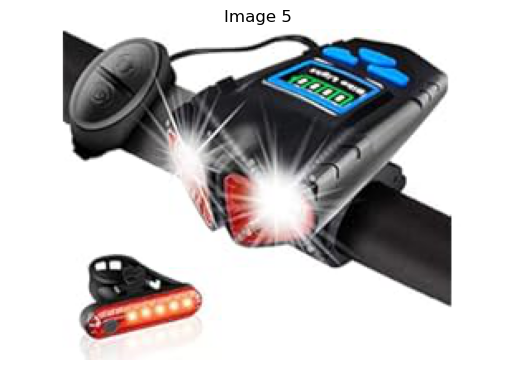

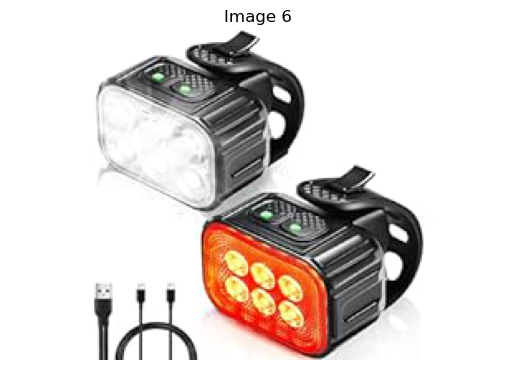

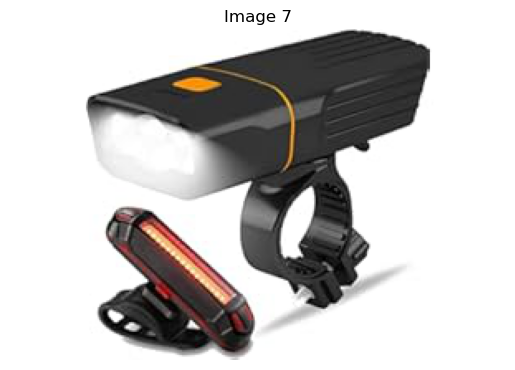

In [91]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(images):
    for idx, img in enumerate(images):
        plt.figure()
        plt.imshow(img)
        plt.title(f'Image {idx}')
        plt.axis('off')
    plt.show()

# Display the images
display_images(images)


In [97]:
# Assuming images is a list of PIL images
image_size = (64, 64)  # Desired image size

# Convert PIL images to numpy arrays
images_np = [np.array(img.resize(image_size)) for img in images]

# Convert numpy arrays to tensors
images_tensors = tf.convert_to_tensor(images_np)

# Create labels (dummy labels in this case, you need to provide the actual labels if available)
labels = tf.zeros((len(images_np),), dtype=tf.int32)  # Replace with actual labels if available

# Combine images and labels into a tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((images_tensors, labels))

# Apply batching and other transformations if needed
test_dataset = test_dataset.batch(32).shuffle(buffer_size=1000)

# Now you can use test_dataset in your model

In [98]:
test_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [71]:
def main(soup, soup_reviews):
    Information = []
    Additional_Information = soup.find("div", {"id":"productDetails_db_sections"}).text.strip()
    Additional_Information_list = re.split(r'\s{2,}', Additional_Information)
    # Use regular expression to split by 2 or more spaces
    #Additional_Information = re.split(r'\s{2,}', Additional_Information)
    #Title
    Product_title = soup.find("span", {"id":"productTitle"}).get_text(strip=True) #Information.append({"Title": Product_title})
    #BSR
    BSR = int(re.search(r'#([\d,]+) in', Additional_Information).group(1).replace(',', ''))
    #category
    category = re.search(r'in (.*?) \(See', Additional_Information).group(1)
    #Sub_Category
    Sub_Category = Additional_Information_list[-1].lstrip('#').strip()
    #Normal Price
    Normal_Price = re.sub(r"[^\d.]", "", soup.find("span", {"class":"a-offscreen"}).text.strip())
    Normal_Price = float(Normal_Price[:Normal_Price.find('.') + 3])  # Slice up to 2 digits after '.'
    # Deal Price
    deal_price_element = soup.find("span", {"class": "a-price a-text-price"})
    if deal_price_element:
        Deal_Price = re.sub(r"[^\d.]", "", deal_price_element.text.strip())
        Deal_Price = float(Deal_Price[:Deal_Price.find('.') + 3])  # Slice up to 2 digits after '.'
    else:
        Deal_Price = None  # or some default value or action
    #Review
    review = float(re.search(r'\b(\d+\.\d)\b', Additional_Information).group(1) if Additional_Information else None)
    #Latest Review
    latest_review = soup.find("a", {"class":"a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold"}).find_all("span")
    latest_review = latest_review[2].text.strip()
    # Number of Ratings & Reviews
    ratings_text = soup_reviews.find("div", {"class":"a-row a-spacing-base a-size-base"}).text.strip().split()
    Num_ratings = int(ratings_text[3].replace(",", ""))  # Remove commas 
    Num_reviews = int(ratings_text[0].replace(",", ""))  # Remove commas
    #Best Seller URL
    Best_Seller_URL = sub_URLs(sub_category_link, baseURL)[0]
    Best_Seller_URL = Best_Seller_URL[0]

    
    
    Information.append({
        "Date": date_today,
        "Title": Product_title,
        "ASIN": ASIN,
        "BSR": BSR,
        "Category": category,
        "Sub Category": Sub_Category,
        "Normal Price": Normal_Price,
        "Deal Price": Deal_Price,
        "Review": review,
        "Latest Review": latest_review,
        "Global Ratings": Num_ratings,
        "Reviews": Num_reviews,
        "Best Seller URL": Best_Seller_URL
        
    })

    return (Information) #this is a list of info


# Create DataFrame
df = pd.DataFrame(main(soup, soup_reviews))
# df = df.reset_index(drop=True) #setting date as index

df


,Date,Title,ASIN,BSR,Category,Sub Category,Normal Price,Deal Price,Review,Latest Review,Global Ratings,Reviews,Best Seller URL
0,23/07/2024,Lumive Rechargeable Bike light Set Super Brigh...,B08FDYL6RZ,6127,Sporting Goods,22 in Bike Headlight-Taillight Combinations,51.99,None,4.2,ممتاز اضاءه جيده جوده,47,117,https://www.amazon.sa/-/en/BIKUUL-Rechargeable...


In [27]:
# saving data into NEW Excel sheet


# Define the file path
file_path = r"C:\Users\Test\projects\sample_project_1\Web_Scrapping\Stock_Daily_check.xlsx"

# Save DataFrame to Excel file
df.to_excel(file_path, index=False, sheet_name='B09GCYH4R6 PH AND TDS METER')
# Save DataFrame to CSV file
#df.to_csv(excel_file_path, index=False)

print(f"DataFrame successfully saved to {file_path}")

DataFrame successfully saved to C:\Users\Test\projects\sample_project_1\Web_Scrapping\Stock_Daily_check.xlsx


In [42]:
file_path = r"C:\Users\Test\projects\sample_project_1\Web_Scrapping\Stock_Daily_check.xlsx"
sheet_name='B09GCYH4R6 PH AND TDS METER'
#sheets represents the entire excel sheet
sheets = load_workbook(file_path)
worksheet = sheets[sheet_name]

for r in dataframe_to_rows(df, index=False, header=False):
    worksheet.append(r)

sheets.save(file_path)
    

In [10]:
!pip install gspread gspread_dataframe google-auth pandas

import gspread
from google.oauth2 import service_account
import pandas as pd
from gspread_dataframe import set_with_dataframe


# Path to your service account JSON file
service_account_key = 'path/to/your/service_account.json'

# Authenticate using service account credentials
creds = service_account.Credentials.from_service_account_file(service_account_key)
gc = gspread.authorize(creds)

ModuleNotFoundError: No module named 'google.colab'